## Introduction and Dataset

The Stanford Sentiment Treebank(SST-2 Dataset | Papers With Code, no date), introduced in (Socher et al., 2013), is a dataset consisting of 11855 labelled reviews used for sentiment analysis. The dataset is derived from another by (Pang and Lee, 2005), the data was processed using the Stanford parser and then annotated by 3 people. SST-2 is the binary form of this dataset, SST-5 contains 5 labels with varying degrees of sentiment analysis. The SST-2 dataset has been chosen as it is utilised in the research paper discussed later. The dataset is almost perfectly balanced (displayed in graphs later in this section).

The task to be performed is sentiment analysis (or binary classification). The goal is to predict whether a given review parse tree is a positive or negative review. The labels are represented as Negative (0) or Positive (1).
The dataset is separated into three sets, the Training Set, Testing Set and Validation Set. The training set is used to fit models, the testing set is used for evaluating their results during the training process. The validation set is used in the evaluation stage and contains data that has been kept separate from the test and train data.


In [15]:
import gensim
import pandas as pd
import numpy as np
import tensorflow as tf
import random

# Ensure consistency between runs
SEED = 1337
def reset_seed():
    random.seed(SEED)
    np.random.seed = SEED
    tf.random.set_seed(SEED)
reset_seed()
tf.config.experimental.enable_op_determinism()

# Train and Test are used for training/hyperparameter tuning
# Validation set is used exclusively for set validation and comparison

# Using the static split so that the results are comparable with the paper being referenced.
train_df = pd.read_table("data/train.tsv", header=None)
test_df = pd.read_table("data/test.tsv", header=None)
validation_df = pd.read_table("data/dev.tsv", header=None)

print(train_df)

train_y = train_df[0].to_numpy()
train_x = train_df[1].to_numpy()

test_y = test_df[0].to_numpy()
test_x = test_df[1].to_numpy()

validation_y = validation_df[0].to_numpy()
validation_x = validation_df[1].to_numpy()

print(len(train_x))
print(len(test_x))
print(len(validation_x))

      0                                                  1
0     1  a stirring , funny and finally transporting re...
1     0  apparently reassembled from the cutting-room f...
2     0  they presume their audience wo n't sit still f...
3     1  this is a visually stunning rumination on love...
4     1  jonathan parker 's bartleby should have been t...
...  ..                                                ...
6915  1  painful , horrifying and oppressively tragic ,...
6916  0  take care is nicely performed by a quintet of ...
6917  0  the script covers huge , heavy topics in a bla...
6918  0  a seriously bad film with seriously warped log...
6919  1  a deliciously nonsensical comedy about a city ...

[6920 rows x 2 columns]
6920
1821
872


In [2]:
print(train_x)
print(train_y)

print(test_x)
print(test_y)

print(validation_x)
print(validation_y)

['a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films'
 'apparently reassembled from the cutting-room floor of any given daytime soap .'
 "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science-fiction elements of bug-eyed monsters and futuristic women in skimpy clothes ."
 ...
 "the script covers huge , heavy topics in a bland , surfacey way that does n't offer any insight into why , for instance , good things happen to bad people ."
 'a seriously bad film with seriously warped logic by writer-director kurt wimmer at the screenplay level .'
 'a deliciously nonsensical comedy about a city coming apart at its seams .']
[1 0 0 ... 0 0 1]
['no movement , no yuks , not much of anything .'
 "a gob of drivel so sickly sweet , even the eager consumers of moore 's pasteurized ditties will retch it up like rancid crème brûlée ."
 'gangs of new york is a

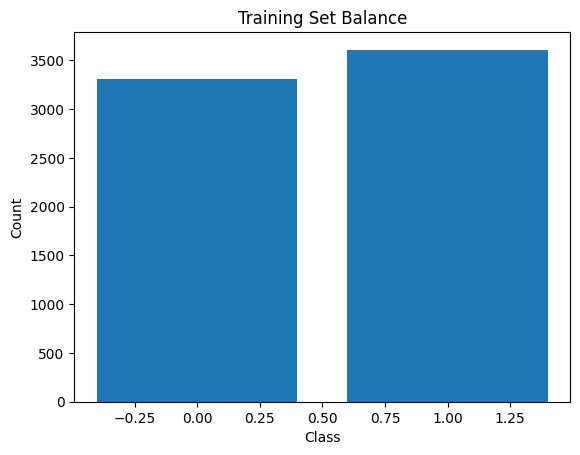

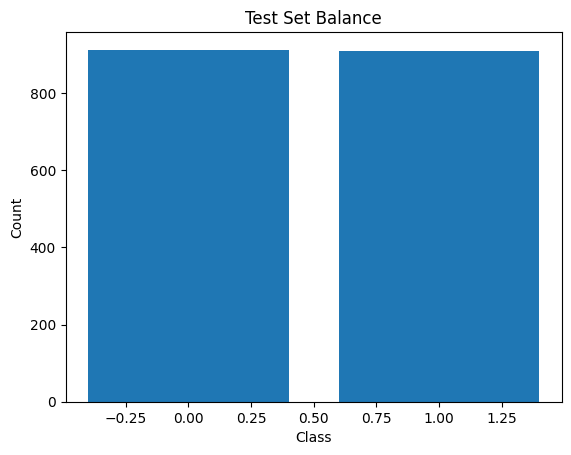

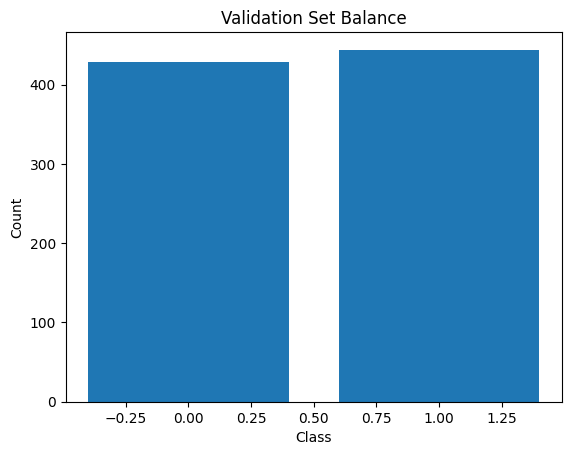

In [3]:
# Check dataset balance
import matplotlib.pyplot as plt

train_counts = train_df[0].value_counts()
plt.bar(train_counts.index, train_counts.values)
plt.title("Training Set Balance")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

test_counts = test_df[0].value_counts()
plt.bar(test_counts.index, test_counts.values)
plt.title("Test Set Balance")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

validation_counts = validation_df[0].value_counts()
plt.bar(validation_counts.index, validation_counts.values)
plt.title("Validation Set Balance")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [4]:
import nltk

# Word tokenizer packages
nltk.download('punkt')
nltk.download('punkt_tab')

# WordNet lemmatizer
nltk.download('wordnet')

# Stopwords set
nltk.download('stopwords')

#https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
nltk.download('averaged_perceptron_tagger_eng')

from nltk.tokenize import word_tokenize #import the tokenize package
from nltk.corpus import wordnet

from nltk.stem import WordNetLemmatizer

# Based on stopwords.words("english")
all_stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves']

# Find most common words to add to stopwords set
token_counts = {}
for x in train_x:
    tokens = word_tokenize(x)
    for token in tokens:
        token_counts[token] = token_counts.get(token, 0) + 1

common_threshold = len(train_x) * 0.75
for token in token_counts:
    if token_counts[token] >= common_threshold:
        all_stopwords.append(token)

# Setup lemmatier
lemmatizer = WordNetLemmatizer()

# Part of Speech (POS) tagging conversion.
# Convert between the NLTK and WordNet representations for the lemmatizer stage
def posToWordnetPos(pos):
    #https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9
    tag_mapping = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_mapping.get(pos[0].upper(), wordnet.NOUN)

# Tokenize sentence and "POS" tag tokens, strip stopwords, lemmatize words and recombine into "sentences"
def preprocess(X):
    prep_text = []
    for x in X:
        tokens = nltk.pos_tag(word_tokenize(x))
        tokens_stripped = [token for token in tokens if token[0] not in all_stopwords]
        tokens_lemmatized = [[lemmatizer.lemmatize(token[0], posToWordnetPos(token[1])) for token in tokens_stripped]]
        prep_text += tokens_lemmatized

    prep_sentences = [" ".join(sentence) for sentence in prep_text]
    return prep_sentences

pre_train_x = preprocess(train_x)
pre_test_x = preprocess(test_x)
pre_validation_x = preprocess(validation_x)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/reecemackie/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [5]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Vectorization Constants
max_features = 15000
sequence_length = 100

# Create a Keras vectorization layer to learn the vocabulary and create vector representations of sentences
# These will be passed into embedding layers for feature extraction
vectorize_layer = layers.TextVectorization(
    standardize=None, # Inputs are already pre-processed
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length,
)

vectorize_layer.adapt(pre_train_x)

def vectorize_text(text):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text)

# Vectorize all inputs up-front to avoid needing to do it again.
prep_train_x = vectorize_text(pre_train_x)
prep_test_x = vectorize_text(pre_test_x)
prep_validation_x = vectorize_text(pre_validation_x)

## Representation Learning

In [7]:
# Training a fresh embedding layer
from sklearn.metrics import accuracy_score, f1_score

# Reset random
reset_seed()

model = keras.Sequential([
    layers.Input((sequence_length,)),
    layers.Embedding(max_features, 128),
    layers.Bidirectional(layers.SimpleRNN(64, activation="relu")),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, epochs=10, batch_size=128)

pred = model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,944,833 (7.42 MB)

 Trainable params: 1,944,833 (7.42 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5275 - loss: 0.6892
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7108 - loss: 0.5900
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8883 - loss: 0.2940
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9578 - loss: 0.1469
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9672 - loss: 0.1051
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9803 - loss: 0.0670
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9910 - loss: 0.0295
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9956 - loss: 0.0165
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9981 - loss: 0.0111
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9991 - loss: 0.0076
31/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

2024-11-24 20:36:46.056297: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-11-24 20:36:46.056526: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
0.7836990595611285


In [10]:
# Custom Trained Word2Vec + Fine-Tuning
from gensim.models import Word2Vec, KeyedVectors

# Reset random
reset_seed()

# Take the learned embeddings and remap them into the order as determined by the Text Vectorization layer being used
def gensim_to_keras_embedding(keyed_vectors: KeyedVectors, tokenizer: layers.TextVectorization, train_embeddings=False):
    vocab = tokenizer.get_vocabulary()
    vocab_size = len(vocab)
    embedding_dim = keyed_vectors.vector_size

    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    # Initializes unknown tokens with a normal distribution
    # This also covers TextVectorization's '[UNK]' for unrecognized tokens
    for i, word in enumerate(vocab):
        if word in keyed_vectors:
            embedding_matrix[i] = keyed_vectors[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

    # Construct the embedding layer, using the extracted weights
    return layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=train_embeddings,
    )

# Train W2V model on pre-processed training data
sentences = [word_tokenize(x) for x in pre_train_x]
w2v_model = Word2Vec(sentences=sentences, vector_size=300, window=5, min_count=1, workers=1, epochs=10)

w2v_embedding_layer = gensim_to_keras_embedding(w2v_model.wv, vectorize_layer, train_embeddings=True)

model = keras.Sequential([
    layers.Input((sequence_length,)),
    w2v_embedding_layer,
    layers.Bidirectional(layers.SimpleRNN(64, activation="relu")),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, epochs=10, batch_size=128)

pred = model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 300)       │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        46,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,861,949 (14.73 MB)

 Trainable params: 3,861,949 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10


2024-11-24 20:41:06.305356: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2024-11-24 20:41:06.305673: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5335 - loss: 0.6937
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6807 - loss: 0.6274
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8184 - loss: 0.4677
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9296 - loss: 0.2314
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9576 - loss: 0.1444
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9854 - loss: 0.0635
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9908 - loss: 0.0446
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9907 - loss: 0.0420
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9924 - loss: 0.0352
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9912 - loss: 0.0387


2024-11-24 20:41:23.121751: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-11-24 20:41:23.122043: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
0.6052463211772233


In [12]:
# Google News 300 Word2Vec + Fine-Tuning

# Reset random
reset_seed()

google_w2v = KeyedVectors.load_word2vec_format("/Users/reecemackie/gensim-data/word2vec-google-news-300/word2vec-google-news-300", binary=True)
w2v_embedding_layer = gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True)

model = keras.Sequential([
    layers.Input((sequence_length,)),
    w2v_embedding_layer,
    layers.Bidirectional(layers.SimpleRNN(64, activation="relu")),
    layers.Dense(1, activation="sigmoid"),
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, epochs=10, batch_size=128)

pred = model.predict(prep_test_x)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 300)       │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │        46,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,861,949 (14.73 MB)

 Trainable params: 3,861,949 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/10


2024-11-24 20:42:18.656932: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2024-11-24 20:42:18.657204: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5695 - loss: 0.6758
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8048 - loss: 0.4379
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9105 - loss: 0.2462
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9419 - loss: 0.1687
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9579 - loss: 0.1221
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9754 - loss: 0.0744
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9912 - loss: 0.0307
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9964 - loss: 0.0155
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9979 - loss: 0.0095
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9989 - loss: 0.0082
22/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

2024-11-24 20:42:34.921745: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-11-24 20:42:34.921991: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
0.8111587982832618


TODO: Explain that Google News W2V is best performing, explain Word2Vec and what I'm doing to it to fit it into Keras.

# Algorithms

## Bi-Directional LSTM

TODO

## GRU

TODO

In [77]:
from keras_tuner import HyperParameters, RandomSearch

# Reset random
reset_seed()

def create_bi_lstm_model(hp: HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input((sequence_length,)))
    model.add(gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True))

    if hp.Boolean("dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Bidirectional(
        layers.LSTM(
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            activation="relu")))

    model.add(layers.Dense(1, activation="sigmoid"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

tuner = RandomSearch(
    hypermodel=create_bi_lstm_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    #overwrite=True,
    directory=".tuning",
    project_name="bilstm",
)

tuner.search_space_summary()

tuner.search(prep_train_x, train_y, epochs=2, validation_data=(prep_validation_x, validation_y))

models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Trial 3 Complete [00h 02m 13s]
val_accuracy: 0.7494266033172607

Best val_accuracy So Far: 0.7746559679508209
Total elapsed time: 00h 07m 18s


/Users/reecemackie/Projects/Rover656/CMM307-AdvancedAI/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 320)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,405,501 (16.81 MB)

 Trainable params: 4,405,501 (16.81 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
# Reset random
reset_seed()

def create_gru_model(hp: HyperParameters):
    model = keras.Sequential()
    model.add(layers.Input((sequence_length,)))
    model.add(gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True))

    if hp.Boolean("emb-dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Bidirectional(
        layers.GRU(
            units=hp.Int("units", min_value=2, max_value=32, step=4),
            #activation="relu"
        )))

    if hp.Boolean("gru-dropout"):
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(1, activation="sigmoid"))

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model

tuner = RandomSearch(
    hypermodel=create_gru_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    #overwrite=True,
    directory=".tuning",
    project_name="gru",
)

tuner.search_space_summary()

tuner.search(prep_train_x, train_y, epochs=2, validation_data=(prep_validation_x, validation_y))

models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Trial 5 Complete [00h 00m 22s]
val_accuracy: 0.7964449524879456

Best val_accuracy So Far: 0.7975917458534241
Total elapsed time: 00h 02m 00s


/Users/reecemackie/Projects/Rover656/CMM307-AdvancedAI/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 300)       │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 4)              │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,818,753 (14.57 MB)

 Trainable params: 3,818,753 (14.57 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation

# Paper Overview

# Paper Implementation

In [107]:
# TODO: Implement the C-LSTM

from keras import regularizers, optimizers

# Reset random
reset_seed()

model = keras.Sequential([
    layers.Input((sequence_length,)),
    # Google Word2Vec embedding
    gensim_to_keras_embedding(google_w2v, vectorize_layer, train_embeddings=True),
    layers.Dropout(0.5),

    # Convolutional layer with 150 filters of size 3
    layers.Conv1D(150, kernel_size=3, activation="relu"),
    # ! Deviation - using MaxPooling1D, without this, model performs ~66%
    layers.MaxPooling1D(pool_size=2),

    # LSTM layer with 150 dimensionality
    layers.LSTM(150),
    layers.Dropout(0.5),

    # Softmax layer with L2 regularization
    #layers.Dense(2, activation="softmax", kernel_regularizer=regularizers.L1L2(0, 0.001)),
    # layers.Dense(2, activation="softmax"),

    # ! Deviation - using sigmoid for binary instead of softmax
    layers.Dense(1, activation="sigmoid", kernel_regularizer=regularizers.L2(0.001), bias_regularizer=regularizers.L2(0.001)),
])

# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])
# model.compile(loss="binary_crossentropy", optimizer=optimizers.RMSprop(), metrics=["accuracy"])
model.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(), metrics=["accuracy"])

model.summary()

print('Fitting Model')
model.fit(x=prep_train_x, y=train_y, validation_data=(prep_validation_x, validation_y), epochs=20)#, epochs=20, batch_size=128)

pred = model.predict(prep_test_x)#.argmax(axis=1)
predictions = (pred > 0.5).astype("int32")
f1 = f1_score(test_y, predictions)
print(f1)

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ (None, 100, 300)       │     3,815,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 100, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 98, 150)        │       135,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 49, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,131,001 (15.76 MB)

 Trainable params: 4,131,001 (15.76 MB)

 Non-trainable params: 0 (0.00 B)

Fitting Model
Epoch 1/20


2024-11-26 01:07:42.256004: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2024-11-26 01:07:42.256355: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

216/217 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5038 - loss: 0.6957

2024-11-26 01:07:48.289593: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2024-11-26 01:07:48.289830: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5039 - loss: 0.6957 - val_accuracy: 0.3979 - val_loss: 0.8463
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.6590 - loss: 0.6257 - val_accuracy: 0.7798 - val_loss: 0.5374
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8252 - loss: 0.4410 - val_accuracy: 0.7672 - val_loss: 0.6347
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8814 - loss: 0.3187 - val_accuracy: 0.7878 - val_loss: 0.6580
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9245 - loss: 0.2348 - val_accuracy: 0.7523 - val_loss: 0.7352
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9174 - loss: 0.2477 - val_accuracy: 0.7890 - val_loss: 0.6237
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9394 - loss: 0.1874 - val_accuracy: 0.7936 - val_loss: 0.7015
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9617 - loss: 0.1309 - val_accuracy: 0.797

2024-11-26 01:09:34.271291: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2024-11-26 01:09:34.271521: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
0.7975460122699386


# Evaluation

# References

Pang, B. and Lee, L. (2005) “Seeing Stars: Exploiting Class Relationships for Sentiment Categorization with Respect to Rating Scales,” Proceedings of the 43rd Annual Meeting on Association for Computational Linguistics  - ACL ’05, pp. 115–124. Available at: https://doi.org/10.3115/1219840.1219855.

Socher, R. et al. (2013) “Recursive Deep Models for Semantic Compositionality Over a Sentiment Treebank,” pp. 1631–1642. Available at: https://aclanthology.org/D13-1170 (Accessed: November 25, 2024).

SST-2 Dataset | Papers With Code (no date). Available at: https://paperswithcode.com/dataset/sst-2 (Accessed: November 25, 2024).

Zhou, C. et al. (2015) “A C-LSTM Neural Network for Text Classification.” Available at: https://arxiv.org/abs/1511.08630v2 (Accessed: November 25, 2024).
